In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from matplotlib.lines import lineStyles
sns.set(context="notebook", style="ticks")
plt.rcParams.update({"font.sans-serif": "Fira Sans Condensed"})

In [13]:
guides = [
    # "ml",
    # "map",
    # "laplace",
    "meanfield",
    "lowrank",
    "radial",
]
# cols = [
#     ("Guide", str),
#     ("Number of parameters", int),
#     ("Wall clock time", float),
#     ("NLL", float),
#     ("Accuracy", float),
#     ("AUROC", float),
#     ("Average confidence", float),
#     ("Average confidence when wrong", float),
#     ("Average confidence when right", float),
# ]
# data = []
# with open("/home/silas/Documents/university/special-course/results.txt", "r") as f:
#     for guide in guides:
#         row = [guide]
#         for col, dt in cols[1:]:
#             line = f.readline()
#             val = dt(line.rstrip("\n").split(": ")[1])
#             row.append(val)
#         data.append(row)
# results = pd.DataFrame(data, columns=[col for col, _ in cols])


In [14]:
# results

In [15]:
import pickle

In [19]:
eval_dataset = "fashionmnist"
results = []
for guide in guides:
    with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        row = [
            data["Inference"],
            data["Trained on"],
            data["Wall clock time"],
            data["Number of parameters"],
            data[f"eval_{eval_dataset}"]["NLL"],
            data[f"eval_{eval_dataset}"]["Accuracy"],
            data[f"eval_{eval_dataset}"]["AUROC"],
            data[f"eval_{eval_dataset}"]["Average confidence"],
            data[f"eval_{eval_dataset}"]["Average confidence when wrong"],
            data[f"eval_{eval_dataset}"]["Average confidence when right"],
        ]
        results.append(row)
results = pd.DataFrame(results, columns=["Inference", "Trained on", "Wall clock time", "Number of parameters", "NLL", "Accuracy", "AUROC", "Average confidence", "Average confidence when wrong", "Average confidence when right"])
results

,Inference,Trained on,Wall clock time,Number of parameters,NLL,Accuracy,AUROC,Average confidence,Average confidence when wrong,Average confidence when right
0,meanfield,MNIST,2097.574770,53012,3.668698,0.0442,0.483869,0.577216,0.583883,0.433048
1,lowrank,MNIST,8983.203084,4373490,3.715054,0.0892,0.440819,0.460544,0.464844,0.416635
2,radial,MNIST,2268.715646,53012,4.487768,0.0639,0.455367,0.680440,0.689259,0.551251


In [20]:
def calibration_curves(y_true, y_prob, y_pred, bins=10):
    real_probs = []
    pred_probs = []
    # count, lims = np.histogram(true_probs, bins=bins)
    count, lims = np.histogram(true_probs, range=(0., 1.), bins=bins)
    for i in range(bins):
        lower, upper = lims[i], lims[i+1]
        mask = (lower <= y_prob) & (y_prob < upper)
        # Find targets for which our prediction lies within a range
        targets_in_range = y_true[mask]
        preds_in_range = y_pred[mask]
        n_in_range = y_true[mask].shape[0]
        range_acc = np.sum(targets_in_range == preds_in_range) / n_in_range

        real_probs.append(range_acc)
        pred_probs.append((lower+upper)/2)
    return real_probs, pred_probs

/tmp/ipykernel_390/630468080.py:13: RuntimeWarning: invalid value encountered in long_scalars
  range_acc = np.sum(targets_in_range == preds_in_range) / n_in_range
/tmp/ipykernel_390/630468080.py:13: RuntimeWarning: invalid value encountered in long_scalars
  range_acc = np.sum(targets_in_range == preds_in_range) / n_in_range


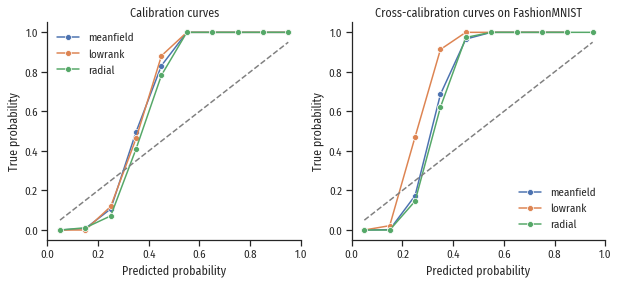

In [21]:
bins = 10

fig, ax = plt.subplots(ncols=2, figsize=(10,4))
for i, (dataset, title) in enumerate([("mnist", "Calibration curves"), ("fashionmnist", "Cross-calibration curves on FashionMNIST")]):
    for guide in guides:
        with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
            data = pickle.load(f)

            targets = data[f"eval_{dataset}"]["Test targets"][:,None]
            probs = data[f"eval_{dataset}"]["Test probabilities"]

            preds = np.argmax(probs, axis=1)[:, None]
            true_probs = np.take_along_axis(probs, targets, axis=1)
            prob_true, prob_pred = calibration_curves(targets, true_probs, preds, bins=bins)

            sns.lineplot(x=prob_pred, y=prob_true, marker="o", label=guide, ax=ax[i])
            # ax.plot(prob_pred, prob_true, label=guide, marker="o")
    ax[i].plot(prob_pred, prob_pred, "--", color="grey")
    ax[i].set(
        xlabel="Predicted probability",
        ylabel="True probability",
        title=title,
        xlim=(0, 1),
    )
    ax[i].legend(frameon=False)
    # ax[i].set_aspect("equal", adjustable="box")
sns.despine(fig)


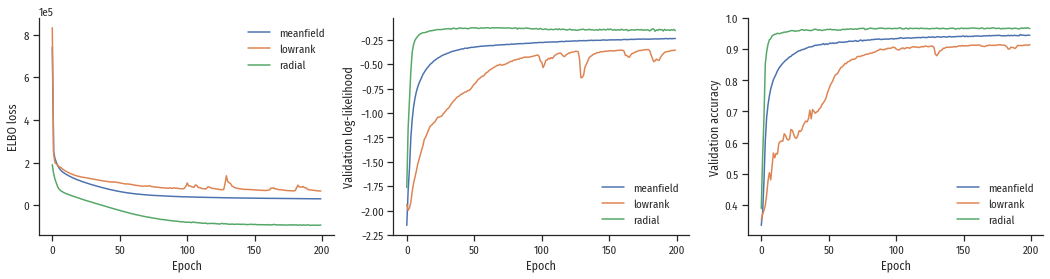

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=(18,4))
for guide in [
    "meanfield",
    "lowrank",
    "radial",
]:
    with open(f"/home/silas/Documents/university/special-course/results/{guide}.pkl", "rb") as f:
        data = pickle.load(f)
        epochs = np.arange(len(data["Training ELBO"]))
        sns.lineplot(x=epochs, y=data["Training ELBO"].squeeze(), label=guide, ax=ax[0])
        sns.lineplot(x=epochs, y=data["Validation log-likelihood"].squeeze(), label=guide, ax=ax[1])
        sns.lineplot(x=epochs, y=data["Validation accuracy"].squeeze(), label=guide, ax=ax[2])
ax[0].set(
    xlabel="Epoch",
    ylabel="ELBO loss",
)
ax[1].set(
    xlabel="Epoch",
    ylabel="Validation log-likelihood",
)
ax[2].set(
    xlabel="Epoch",
    ylabel="Validation accuracy",
)
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[2].legend(frameon=False)
sns.despine(fig)